In [34]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string
import re
import joblib
import streamlit as st

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

In [35]:
#  Step 1: Load and Clean Data
df = pd.read_csv(r"C:\Users\ASUS\OneDrive\Documents\LLM\spam.csv", encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'message']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [36]:
df

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [37]:
# From the above data we can see that Ham messages are mapped to the value 0 and spam messages are mapped to the value 1.

In [38]:
#  Step 2: EDA (Exploratory Data Analysis)
df['length'] = df['message'].apply(len)
label_counts = df['label'].value_counts()

In [39]:
# Word clouds
spam_words = ' '.join(df[df['label'] == 1]['message'])
ham_words = ' '.join(df[df['label'] == 0]['message'])

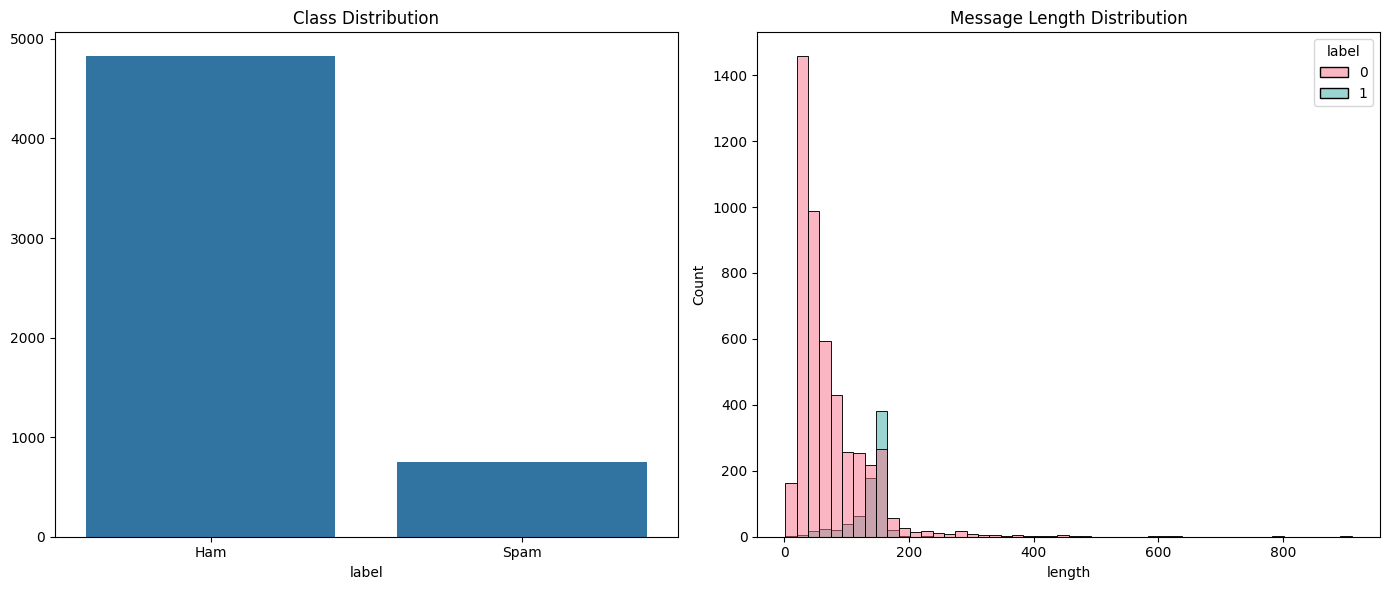

In [40]:
# Show plots
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.title("Class Distribution")

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='length', hue='label', bins=50, palette='husl')
plt.title("Message Length Distribution")
plt.tight_layout()
plt.show()

In [41]:
# The above plot shows that the dataset comtains more Ham messages compare to spam.
# Every messages are normally distributed and the ham message has high message length compare to spam.

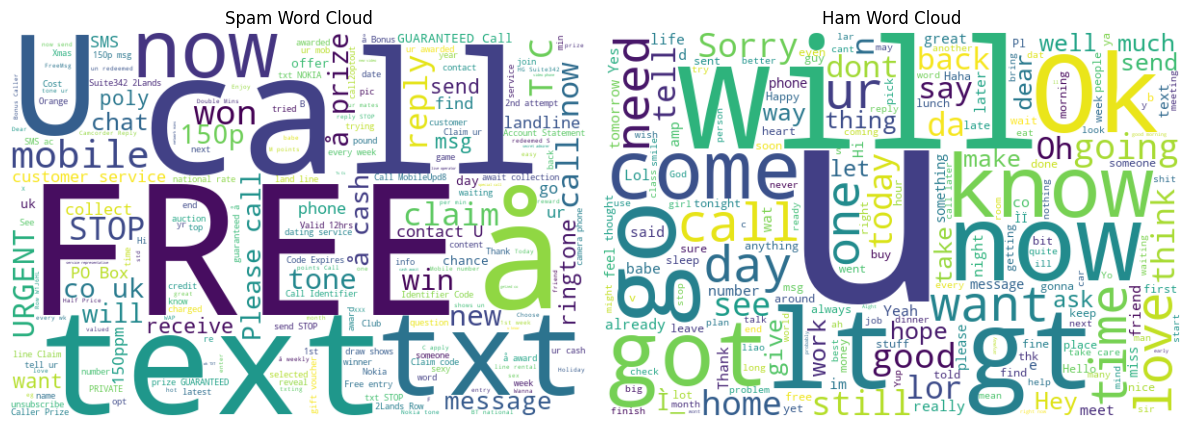

In [42]:
# Word clouds
wc1 = WordCloud(width=600, height=400, background_color='white').generate(spam_words)
wc2 = WordCloud(width=600, height=400, background_color='white').generate(ham_words)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wc1, interpolation='bilinear')
plt.axis('off')
plt.title("Spam Word Cloud")

plt.subplot(1, 2, 2)
plt.imshow(wc2, interpolation='bilinear')
plt.axis('off')
plt.title("Ham Word Cloud")
plt.tight_layout()
plt.show()

In [43]:
# From the above word cloud we can see what are the commanly used words in the Ham and Spam messages.

In [44]:
#  Step 3: Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['clean_message'] = df['message'].apply(clean_text)

In [45]:
# The above function is doing the text normalization which is needed for the text normalization.

In [46]:
# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_message'], df['label'], test_size=0.3, random_state=42)

In [47]:
#  Step 5: Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [48]:
#  Step 6: Try Multiple Models
def evaluate_model(model, name):
    model.fit(X_train_vec, y_train)
    preds = model.predict(X_test_vec)
    acc = accuracy_score(y_test, preds)
    print(f"{name} Accuracy: {acc:.4f}")
    return name, acc, model

results = []
results.append(evaluate_model(MultinomialNB(), "MultinomialNB"))
results.append(evaluate_model(LogisticRegression(max_iter=1000), "Logistic Regression"))
results.append(evaluate_model(LinearSVC(), "Linear SVM"))
results.append(evaluate_model(RandomForestClassifier(), "Random Forest"))

MultinomialNB Accuracy: 0.9647
Logistic Regression Accuracy: 0.9486
Linear SVM Accuracy: 0.9797


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Random Forest Accuracy: 0.9701


In [49]:
# We use 4 type of models (MultinomialNB Accuracy, Logistic Regression Accuracy, Linear SVM Accuracy, Random Forest Accuracy) to test the accuracy of our data.
# From the models the Linear SVM is considered as the best model.

In [50]:
# Step 7: Select Best Model
best_model_info = max(results, key=lambda x: x[1])
best_name, best_acc, best_model = best_model_info
print(f"\n Best Model: {best_name} with Accuracy: {best_acc:.4f}")


 Best Model: Linear SVM with Accuracy: 0.9797


In [51]:
#  Step 8: Final Classification Report
final_preds = best_model.predict(X_test_vec)
print("\nClassification Report:\n")
print(classification_report(y_test, final_preds, target_names=['ham', 'spam']))


Classification Report:

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1453
        spam       0.98      0.86      0.92       219

    accuracy                           0.98      1672
   macro avg       0.98      0.93      0.95      1672
weighted avg       0.98      0.98      0.98      1672



In [52]:
#  Step 9: Build Final Pipeline on Full Data
final_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('svm', LinearSVC())  # use best model name if different
])
final_pipeline.fit(df['clean_message'], df['label'])

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('svm', LinearSVC())])